In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
# using DifferentialEquations
# using DiffEqFlux
# using Optim
# using ForwardDiff
using DelimitedFiles
using LineSearches

In [6]:
function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

# dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
# ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

# dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [108]:
ps = readdlm("tmp_paramsmm20.txt")
ls = readdlm("tmp_lsmm20.txt")
size(ps), ls[end-5:end]

((180, 9), [6.680547762233369e-5, 6.685263207317771e-5, 6.686254141002879e-5, 6.686378271236748e-5, 6.68638763272611e-5, 6.68642047771395e-5])

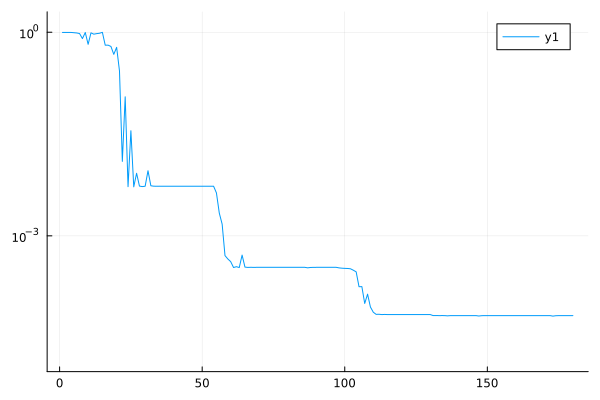

In [109]:
plot(ls,yscale=:log10,ylim=(1e-5,2))

In [10]:
times = LinRange(0,30,1000) ;

In [96]:
ps[1:end,1]

45-element Vector{Float64}:
  -2.1972245773362182
  -2.1916134548193806
  -2.1691689647520307
  -2.0793910044826305
  -1.7202791634050298
  -1.5439551619232357
  -0.8386591559960592
  -1.4401542926523287
  -1.5271047376385214
  -1.5382150695419745
   ⋮
  -0.9804485995243092
  -0.9804487245059983
  -0.9804487581568689
  -0.9804487580323422
  -0.9804487581568689
 208.07446709081043
  70.07761570988049
  22.595242823559463
   6.8163107750591365

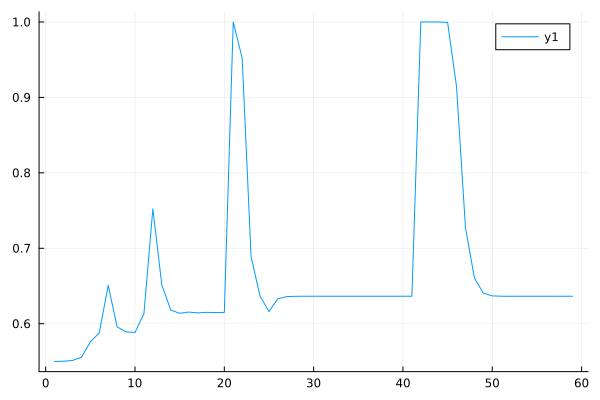

In [106]:
ps = readdlm("../RobustPhiExt/tmp_awg55_paramsm18.txt")
# plot(ps[50:end,:],legend=nothing)
plot(limit_func.(ps[1:end,1],0.5,1))

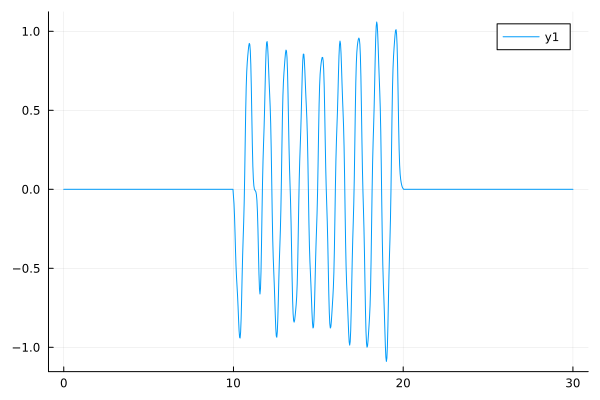

In [107]:
h_times = LinRange(10,20,50+2)[2:end-1]
dt = h_times[2] - h_times[1]
function pulse(p, t)
    if  t < 10 || t > 20
        return 0
    end
    out = 0
    w_start = exp( - 5/(2*dt^2) * (t - 10)^2)
    w_end = exp( - 5/(2*dt^2) * (t - 20)^2)
    w_sum = w_start + w_end
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i+1] * w
        w_sum += w
    end
    # envelope(t)*out/w_sum
    out/w_sum
end
times = LinRange(0,30,1000)
plot(times, [pulse(ps[end,:],t) for t in times])

In [16]:
readdlm("tmp_lsmm2.txt")[1:9]

9-element Vector{Float64}:
 0.9940422753061071
 0.9938651280478812
 0.9934675048221939
 0.9938453835361382
 0.9844303004809606
 0.9760329490032199
 0.9567153096549167
 0.8060668547112209
 0.9918924419557211

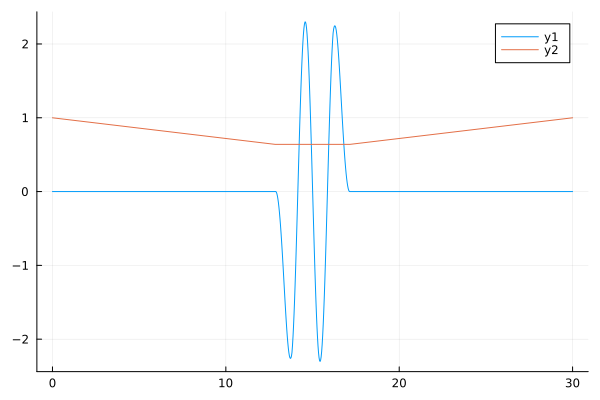

In [104]:
ind = 120
plot(times, [[pulse(ps[ind,:],t) for t in times],
             [alpha(ps[ind,:],t) for t in times]])

In [98]:
x3 = [-4 ; 0 ; 1]
v1 = [-0.84 0.14 0.52]
v2 = [0.53 0.39 0.75]
v1*x3, v2*x3

([3.88], [-1.37])

In [106]:
(1 - 0.9443)/0.9443 * (49.8364^2 + 2.9631^2 + 2.0575^2)

147.26789984970236

In [107]:
sqrt(147.26789984970236)

12.13539862755659

In [104]:
V = [0.5133 0.4679 -0.7071
; 0.5109 -0.8077 -0.2036
; 0.4915 0.3611 0.4769
; 0.4838 -0.0116 0.4808]

v1 = [-0.1327 ; 0.2168 ; 0.6330 ; -0.7312]
v2 = [0.8180 ; -0.2276 ; -0.5273 ; -0.0336]
V'*v1

3-element Vector{Float64}:
  1.3149999999989559e-5
 -0.00014147000000000465
  8.430000000003712e-6

In [105]:
V'*v2

3-element Vector{Float64}:
  0.028174929999999987
  0.37655645
 -0.7996926899999999